### Project individual IR patches of PV modules onto common ground plane

In [1]:
import os
import re
import time
import json
import csv
from collections import defaultdict
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import Affine

import sys
sys.path.append("../..")

from extractor.common import get_immediate_subdirectories, \
    to_celsius, preprocess_radiometric_frame
from extractor.mapping.geotransforms import enu2geodetic

In [2]:
def truncate_patch(patch, margin=0.1):
    """Truncates module edges by margin (percent of width) to remove module frame."""
    width = patch.shape[1]
    margin_px = int(margin*width)
    patch = patch[margin_px:-margin_px, margin_px:-margin_px]
    return patch


def get_max_mean_temp_patch(patch_files, patch_idxs_sun_reflections=[]):
    """Returns index of the patch in patch_files with largest mean temperature.
    Optionally ignores patches with sun reflections."""
    if len(patch_files) == 0:
        return None
    patch_idx = 0
    previous_mean_temp = -np.inf
    for idx, patch_file in enumerate(patch_files):
        if idx in patch_idxs_sun_reflections:  # ignore patches with sun reflections
            continue
        patch = cv2.imread(patch_file, cv2.IMREAD_ANYDEPTH)
        if patch is not None:
            patch = truncate_patch(patch, margin=0.2)
            mean_temp = to_celsius(np.mean(patch))
            if mean_temp > previous_mean_temp:
                patch_idx = idx
                previous_mean_temp = mean_temp
    return patch_idx

def get_patch(patches_root, track_id, tracks_per_id):
    """Of multiple patches load the one with highest mean temperature."""
    # determine which patch has the largest mean temperature
    patch_files = [os.path.join(patches_root, track_id, "{}_{}.tiff".format(frame_name, mask_name))
        for frame_name, mask_name in tracks_per_id[track_id]]
    patch_idx = get_max_mean_temp_patch(patch_files)
    # load patch
    patch = cv2.imread(patch_files[patch_idx], cv2.IMREAD_ANYDEPTH)
    patch = preprocess_radiometric_frame(patch, equalize_hist=True)  # we should only do that for the entire image but not per patch!
    return patch


def load_tracks(tracks_file):
    """Load Tracks CSV file."""
    tracks_per_frame = defaultdict(list)
    tracks_per_id = defaultdict(list)
    with open(tracks_file, newline='', encoding="utf-8-sig") as csvfile:  # specifying the encoding skips optional BOM
        # automatically infer CSV file format
        dialect = csv.Sniffer().sniff(csvfile.readline(), delimiters=",;")
        csvfile.seek(0)
        csvreader = csv.reader(csvfile, dialect)
        for row in csvreader:
            frame_name = row[0]
            mask_name = row[1]
            track_id = row[2]
            tracks_per_frame[frame_name].append((mask_name, track_id))
            tracks_per_id[track_id].append((frame_name, mask_name))
    return tracks_per_frame, tracks_per_id

In [3]:
# get extent of the plant, i.e. find minimum and maximum latitude and longitudes of all modules
def get_extent(module_corners):
    corners = np.vstack(list(module_corners.values()))
    min_east = np.min(corners[:, 0])
    max_east = np.max(corners[:, 0])
    min_north = np.min(corners[:, 1])
    max_north = np.max(corners[:, 1])
    return max_east, min_east, max_north, min_north


def get_transform_geo2img(output_width, output_height, max_north, 
    min_north, max_east, min_east):
    """Computes and affine transformation matrix for transforming 
    geo coordinates (east, north, height) to image coordinates."""
    src_points = np.array([[min_east, min_north],
                           [max_east, min_north],
                           [max_east, max_north]])
    dst_points = np.array([[0, 0],
                           [output_width, 0],
                           [output_width, output_height]])
    transform = cv2.getAffineTransform(
            src_points.astype(np.float32), dst_points.astype(np.float32))
    return transform


def geo2img(pts_geo, transform):
    """Transforms geo coordinates to image coordinates."""
    pts_img = (transform @ cv2.convertPointsToHomogeneous(pts_geo.astype(np.float32).reshape(-1, 1, 2)).reshape(-1, 3).T).T
    return pts_img

In [4]:
work_dir = "/storage-2/pvextractor-georeferencing/20210510_Schmalenbach/workdir"
mapping_root = os.path.join(work_dir, "mapping")

# get origin of local ECEF coordinates
gps_origin = pickle.load(open(os.path.join(mapping_root, "reference_lla.pkl"), "rb"))

modules = pickle.load(open(os.path.join(mapping_root, "modules.pkl"), "rb"))
module_corners = modules["corners"]
module_centers = modules["centers"]

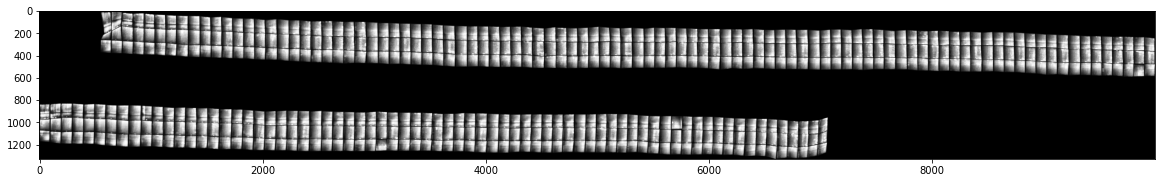

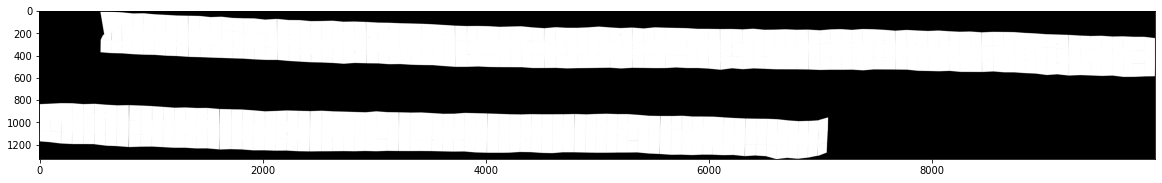

In [5]:
# get geographical extent of reconstruction
max_east, min_east, max_north, min_north = get_extent(module_corners)

# determine size of output image
output_width = 10000  # px
scale = output_width / (max_east - min_east)
output_height = int(np.ceil(scale * (max_north - min_north)))

output_image = np.zeros((output_height, output_width), dtype=np.uint8)
output_mask = np.zeros((output_height, output_width), dtype=np.uint8)

transform = get_transform_geo2img(output_width, output_height, max_north, 
    min_north, max_east, min_east)

# project each module patch onto the z=0 plane
for cluster_dir in sorted(get_immediate_subdirectories(mapping_root)):

    cluster_idx = int(re.findall(r'\d+', cluster_dir)[0])
    tracks_file = os.path.join(work_dir, "tracking", "tracks_cluster_{:06d}.csv".format(cluster_idx))
    patches_root = os.path.join(work_dir, "patches", cluster_dir, "radiometric")
    
    if not os.path.isfile(tracks_file):
        continue
        
    # load tracks file
    _, tracks_per_id = load_tracks(tracks_file)
    
    for track_id in tracks_per_id.keys():
        try:
            corners = module_corners[track_id]
        except KeyError:
            continue
        
        patch = get_patch(patches_root, track_id, tracks_per_id)
        h, w = patch.shape[:2]
        
        # find homography between patch and output image
        img_points = np.array([[0, 0],
                               [w, 0],
                               [w, h],
                               [0, h]])

        dst_points = geo2img(corners[:, :-1], transform)    
        transmtx = cv2.getPerspectiveTransform(img_points.astype(np.float32), dst_points.astype(np.float32))

        # project patch into output image
        warped_patch = cv2.warpPerspective(patch, transmtx, (output_width, output_height), cv2.INTER_CUBIC, cv2.BORDER_REFLECT)
        
        mask = np.full((h, w), 255, dtype=np.uint8)
        warped_mask = cv2.warpPerspective(mask, transmtx, (output_width, output_height), cv2.INTER_NEAREST)

        output_image = cv2.bitwise_or(output_image, warped_patch)
        output_mask = cv2.bitwise_or(output_mask, warped_mask)
        
fig = plt.figure()
fig.set_size_inches(20, 10)
plt.imshow(output_image, cmap="gray")
plt.show()

fig = plt.figure()
fig.set_size_inches(20, 10)
plt.imshow(output_mask, cmap="gray")
plt.show()

In [8]:
output_image_rgba = cv2.merge((output_image, output_image, output_image, output_mask))
cv2.imwrite(os.path.join(mapping_root, "output.png"), output_image_rgba)

True

### Create GeoTIFF(s)

In [10]:
def store_geotiff(filepath, output_image, max_lat, min_lat, max_lon, min_lon):    
    # get affine transform between image coordinates and bounding latitude and longitude
    res_lon = (lon_b - lon_a) / output_image.shape[1]
    res_lat = (lat_c - lat_a) / output_image.shape[0]
    translation = Affine.translation(lon_a - res_lon / 2, lat_a - res_lat / 2)
    scale = Affine.scale(res_lon, res_lat)
    transform = translation * scale
    
    count = 1
    if output_image.ndim == 3 and output_image.shape[-1] == 4:
        count = 4
    
    # save geo tiff
    with rasterio.open(
        filepath,
        'w',
        driver='GTiff',
        height=output_image.shape[0],
        width=output_image.shape[1],
        dtype=output_image.dtype,
        crs='+proj=latlong',
        transform=transform,
        #nodata=None,
        count=count
    ) as dst:
        if output_image.ndim == 3 and output_image.shape[-1] == 4:
            dst.write(output_image[..., 0], 1)
            dst.write(output_image[..., 1], 2)
            dst.write(output_image[..., 2], 3)
            dst.write(output_image[..., 3], 4)
        elif output_image.ndim == 2:
            dst.write(output_image, 1)

In [11]:
# convert east-north-height to WGS-84 latitude and longitude
# Note: setting height to zero is not exactly correct, but error is small
#       lon_a == lon_b and lat_b == lat_c should hold, however due to 
#       setting height zero this is violated
lat_a, lon_a, _ = enu2geodetic(min_east, min_north, 0.0, *gps_origin)  
lat_b, lon_b, _ = enu2geodetic(max_east, min_north, 0.0, *gps_origin)
lat_c, lon_c, _ = enu2geodetic(max_east, max_north, 0.0, *gps_origin)

max_lat, min_lat = lat_c, lat_a
max_lon, min_lon = lon_b, lon_a

file = os.path.join(mapping_root, 'output.tif')
store_geotiff(file, output_image_rgba, max_lat, min_lat, max_lon, min_lon)